Final Shift Factors: [0, -2.3132952832384475, -1.0050079152414022, 0.777443284866709, 1.3985615266649714]
Final SSD: 1527.7077783941606


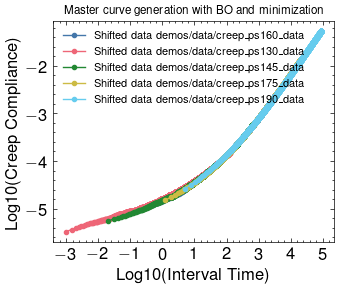

In [2]:
import pandas as pd
import numpy as np
import skopt
from scipy.optimize import minimize
from skopt import gp_minimize
from skopt.space import Real
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'nature', 'bright'])


# Define column names
columns = ['Time', 'Creep Compliance']

# Number of iterations
num_iterations = 100

# Initialize array to store shift factor history
shift_factors_history = []

# Define a threshold for stopping (adjust this value based on your data)
ssd_threshold = 1  # Example threshold

# List of files to process
filenames = [
    'demos/data/creep_ps160_data.csv',  # Reference file with fixed shift factor 0
    'demos/data/creep_ps130_data.csv',
    'demos/data/creep_ps145_data.csv',
    'demos/data/creep_ps175_data.csv',    
    'demos/data/creep_ps190_data.csv',]

# Reference shift factor (always 0 for the reference file)
reference_shift_factor = 0

# Load the reference data (first file)
reference_data = pd.read_csv(filenames[0], decimal='.', sep='\t')
reference_data.columns = columns
reference_log_interval_time = np.log10(reference_data['Time'])
reference_log_creep_compliance = np.log10(reference_data['Creep Compliance'])

# Define the SSD calculation function
def calculate_ssd(shift_factors, filenames, reference_log_interval_time, reference_log_creep_compliance):
    ssd = 0.0
    for i, filename in enumerate(filenames):
        if i == 0:  # Skip reference file
            continue
        data = pd.read_csv(filename, decimal='.', encoding='utf-8', sep='\t')
        data.columns = columns
        log_interval_time = np.log10(data['Time'])
        log_creep_compliance = np.log10(data['Creep Compliance'])

        # Apply shift factor
        log_interval_time_shifted = log_interval_time + shift_factors[i]

        # Interpolate to compare with reference
        interpolated_creep_compliance = np.interp(reference_log_interval_time, log_interval_time_shifted, log_creep_compliance)
        ssd += np.sum((interpolated_creep_compliance - reference_log_creep_compliance) ** 2)
    
    return ssd

# Define the surrogate objective function for Bayesian Optimization
def surrogate_objective(shift_factors):
    return calculate_ssd([0] + list(shift_factors), filenames, reference_log_interval_time, reference_log_creep_compliance)

# Define the search space for Bayesian Optimization
search_space = [Real(-4, 4) for _ in range(len(filenames) - 1)]

# Perform Bayesian Optimization to find a promising region
result_bo = gp_minimize(surrogate_objective, search_space, acq_func='EI', n_calls=50, random_state=0)

# Use the result from Bayesian Optimization as the initial guess for local optimization
initial_shift_factors = result_bo.x

# Define bounds for local optimization
bounds = [(-6, 6) for _ in range(len(filenames) - 1)]

# Perform local optimization to refine the solution
def local_optimization_objective(shift_factors):
    return calculate_ssd([0] + list(shift_factors), filenames, reference_log_interval_time, reference_log_creep_compliance)

result_local = minimize(local_optimization_objective, initial_shift_factors, bounds=bounds, method='Powell')

# Extract the final shift factors
final_shift_factors = [0] + list(result_local.x)
print(f"Final Shift Factors: {final_shift_factors}")
print(f"Final SSD: {result_local.fun}")

time = []
J_creep = []

# Visualization
plt.figure(figsize=(3.5, 3))
for i, filename in enumerate(filenames):
    # Load the data
    data = pd.read_csv(filename, decimal='.', encoding='utf-8', sep='\t')
    data.columns = columns

    # Extract the relevant columns and apply log10
    log_interval_time = np.log10(data['Time'])
    log_creep_compliance = np.log10(data['Creep Compliance'])

    # Apply shift factor
    log_interval_time_shifted = log_interval_time + final_shift_factors[i]

    # Store data
    # Convert log data back to linear scale and concatenate
    time = np.concatenate([time, 10**log_interval_time_shifted])       # Merge the time arrays
    J_creep = np.concatenate([J_creep, 10**log_creep_compliance])      # Merge the J_creep arrays

    # Plot the data
    plt.plot(log_interval_time_shifted, log_creep_compliance, 'o-', label=f'Shifted data {filename.split(".")[0]}')

plt.xlabel('Log10(Interval Time)', fontsize=12)
plt.ylabel('Log10(Creep Compliance)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Master curve generation with BO and minimization')
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig(f'master_curve_rel_ps_tref_160.pdf', format='pdf')
plt.show()

In [3]:
# Create a DataFrame from time and J_creep arrays
df = pd.DataFrame({'Time': time, 'J_creep': J_creep})

# Clean NaNs
df_cleaned = df.dropna()

# Reorder the DataFrame by 'Time' from minimum to maximum
df_sorted = df_cleaned.sort_values(by='Time', ascending=True).reset_index(drop=True)

# Show the DataFrame (optional)
print(df_sorted)

               Time   J_creep
0          0.000978  0.000003
1          0.001465  0.000004
2          0.001951  0.000004
3          0.002438  0.000004
4          0.002922  0.000004
...             ...       ...
46789  89878.533001  0.053456
46790  89953.640410  0.053510
46791  90053.783623  0.053565
46792  90153.926835  0.053620
46793  90254.070047  0.053673

[46794 rows x 2 columns]


Predicted Model: FractionalMaxwell


/m/scicomp/software/anaconda-ci/aalto-ubuntu2004-anaconda/software/anaconda/2023-04/e0d50272/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.4.2 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/m/scicomp/software/anaconda-ci/aalto-ubuntu2004-anaconda/software/anaconda/2023-04/e0d50272/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.4.2 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/m/scicomp/software/anaconda-ci/aalto-ubuntu2004-anaconda/sof

Best initial guess was: [782315.1746244943, 1614617.487238916, 0.40832064783362376, 0.2959594323012923]
G: 73566.30531799514
V: 1089801.9534586484
alpha: 0.9575404982957804
beta: 0.2834335289115826
RSS: 22.21551324018046
Mean Percentage Error: 1.38%


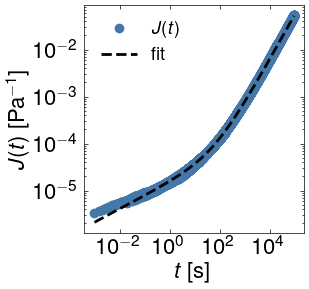

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyRheo.creep_model import CreepModel

# Load data
time_mc = df_sorted['Time'].values
J_creep_mc = df_sorted['J_creep'].values

# Downsample 'time' and 'J_creep' by selecting every 100th row
time = time_mc[::1]
J_creep = J_creep_mc[::1]

# Model fitting
model = CreepModel(model="auto", initial_guesses="random", num_initial_guesses=10, minimization_algorithm="Powell")
model.fit(time, J_creep)

model.print_parameters()
model.print_error()
model.plot(time, J_creep, savefig=False)

In [5]:
time_predict = np.logspace(np.min(np.log10(time_mc)), np.max(np.log10(time_mc)), 100)
J_creep_predict = model.predict(time_predict)

/tmp/ipykernel_34174/1392305383.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20c', 7)


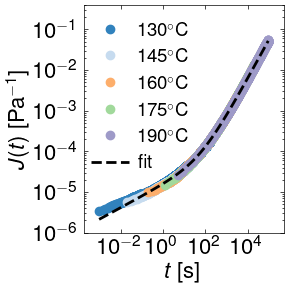

In [6]:
from matplotlib.ticker import LogLocator

# List of files to process
filenames = [
    'demos/data/creep_ps130_data.csv',  # Reference file with fixed shift factor 0
    'demos/data/creep_ps145_data.csv',
    'demos/data/creep_ps160_data.csv',
    'demos/data/creep_ps175_data.csv',    
    'demos/data/creep_ps190_data.csv',]

s_final_shift_factors = sorted(final_shift_factors)


# Adjusted size for better visibility of multiple plots
plt.figure(figsize=(3, 3))

# Reordered labels based on temperatures (minimum temperature first)
labels = ["$130^{\circ}$C", "$145^{\circ}$C", "$160^{\circ}$C", "$175^{\circ}$C", "$190^{\circ}$C"]

# Colors 
from matplotlib import cm

num_files = len(filenames)

# Generate colors using a colormap
colormap = cm.get_cmap('tab20c', 7)
colors = [colormap(i) for i in range(num_files)]

# Visualization
for i, filename in enumerate(filenames):
    # Load the data
    data = pd.read_csv(filename, decimal='.', encoding='utf-8', sep='\t')
    data.columns = columns

    # Extract the relevant columns and apply log10
    log_interval_time = np.log10(data['Time'])
    log_creep_compliance = np.log10(data['Creep Compliance'])

    # Apply shift factor
    log_interval_time_shifted = log_interval_time + s_final_shift_factors[i]

    # Store data
    # Convert log data back to linear scale and concatenate
    time = np.concatenate([time, 10**log_interval_time_shifted])            # Merge the time arrays
    J_creep = np.concatenate([J_creep, 10**log_creep_compliance])  # Merge the J_creep arrays
    
    # Assign label from reordered list based on the current index i
    label = labels[i]
    
    # Plot the data
    plt.plot(10**log_interval_time_shifted, 10**log_creep_compliance, 'o', color=colors[i], markersize=6, alpha=1, label=label)


# Plot the results
#plt.plot(time_mc, J_creep_mc, 'o', markersize=6, label='master curve')
plt.plot(time_predict, J_creep_predict, '--', color="k", lw=2, label='fit')

# Customize the plot
plt.xscale("log")
plt.yscale("log")

# Adjust the tick locations on both axes to avoid crowding
plt.gca().xaxis.set_major_locator(LogLocator(base=10.0, numticks=5))  # X-axis log ticks
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, numticks=5))  # Y-axis log ticks

# Font sizes for the ticks, labels, and legend
plt.xlim(2e-4, 5e5)
plt.ylim(1e-6, 4e-1)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'$t$ [s]', fontsize=16)
plt.ylabel(r'$J(t)$ [Pa$^{-1}$]', fontsize=16)
plt.legend(fontsize=13.5, loc='upper left', handletextpad=0.5, bbox_to_anchor=(-0.05, 1) )

# Add final touches to the plot
plt.grid(False)
plt.tight_layout()

# Save and display the plot
plt.savefig("ps_creep_mc.pdf", format="pdf", bbox_inches='tight')
plt.show()